*****************************************************
# The Social Web Assignment 4: Recommendation

- Instructors: Davide Ceolin, Emma Beauxis-Aussalet.
- TAs: Zubaria Inayat, Maxim Sergeev, Zhuofan Mei, Alexander Schmatz, Ling Jin.
- Exercises for Hands-on session 4 
*****************************************************

In this notebook you will use the similarity measures to provide recommendations by comparing users and content based on expressed preferences (ratings). You will also explore textual similarity using a very popular natural language processing library, NLTK. Finally, you will explore recommendations on the Reddit platform.

Required packages:
* feedparser, praw,  nltk

In [ ]:
import sys

!pip install feedparser
!pip install praw
!pip install nltk

In the snippets below, you can find:
* creation of a small toy database in form of a dictionary of dictionaries;
* issuing several similarity measures based on critics' preferences; and
* use those values to obtain meaningful statistics pertaining a user.

# Movie preferences of movie critics
As example data, let us define a python dictionary of movie critics and their ratings of a small set of movies


In [ ]:
critics = {
    'Lisa Rose': {
        'Lady in the Water': 2.5,
        'Snakes on a Plane': 3.5,
        'Just My Luck': 3.0,
        'Superman Returns': 3.5,
        'You, Me and Dupree': 2.5,
        'The Night Listener': 3.0,
    },
    'Gene Seymour': {
        'Lady in the Water': 3.0,
        'Snakes on a Plane': 3.5,
        'Just My Luck': 1.5,
        'Superman Returns': 5.0,
        'The Night Listener': 3.0,
        'You, Me and Dupree': 3.5,
    },
    'Michael Phillips': {
        'Lady in the Water': 2.5,
        'Snakes on a Plane': 3.0,
        'Superman Returns': 3.5,
        'The Night Listener': 4.0,
    },
    'Claudia Puig': {
        'Snakes on a Plane': 3.5,
        'Just My Luck': 3.0,
        'The Night Listener': 4.5,
        'Superman Returns': 4.0,
        'You, Me and Dupree': 2.5,
    },
    'Mick LaSalle': {
        'Lady in the Water': 3.0,
        'Snakes on a Plane': 4.0,
        'Just My Luck': 2.0,
        'Superman Returns': 3.0,
        'The Night Listener': 3.0,
        'You, Me and Dupree': 2.0,
    },
    'Jack Matthews': {
        'Lady in the Water': 3.0,
        'Snakes on a Plane': 4.0,
        'The Night Listener': 3.0,
        'Superman Returns': 5.0,
        'You, Me and Dupree': 3.5,
    },
    'Toby': {'Snakes on a Plane': 4.5, 
             'You, Me and Dupree': 1.0,
             'Superman Returns': 4.0},
}

# **Exercise 1: Finding Similar Users**

In the code below, two different simililarity measures are used: Euclidean distance and the Pearson correlation. If you are not familiar with them, we recommend you look them up to deepen your understanding.

## Euclidian distance

To assess the degree similarity between critics given their respective preferences, we can use the euclidian distance.
Its formula for an N-dimensional space is is: 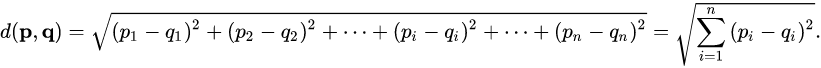
Because we want a smaller distance to indicate a larger similarity, we will use 1/d(p,q) as our similarity value:

In [ ]:
from math import sqrt

def sim_distance(p1, p2, show_common_dims=False, prefs=critics):
    '''
    Returns a distance-based similarity score between two critics.
    '''

    # Get the list of shared_items
    common_items = []
    for movie in prefs[p1]:
        if movie in prefs[p2]:
            common_items.append(movie)
    # If they have no ratings in common, return 0
    if len(common_items) == 0:
        return 0
    if show_common_dims:
        print("common dimensions between {} and {}: ".format(p1, p2) + str(len(common_items)))
    # Add up the squares of all the differences
    sum_of_squares = sum([pow(prefs[p1][movie] - prefs[p2][movie], 2) for movie in common_items])
    
    # return sqrt(sum_of_squares)
    return 1 / sqrt(sum_of_squares)

Using this simple formula, you can calculate a similarity between two critics:

In [ ]:
# get the distance between 'Lisa Rose' and 'Gene Seymour'
sim_distance('Lisa Rose','Gene Seymour') 

Try this with other names so you can see who is closer or further.

Name at least two problems with the sim_distance function as it is defined above. 

Problems:
1. If two critics generally judge the same movies as good or bad, but one is a bit more strict (so gives more lower grades), they
will be dissimilar with this distcance.
2. One movie that they rate differently will increase the distance by a lot
3. not normalized so distance tends to increase with increased movie size
    

A different measure of similarity can be given by pearson correlation.
Which follows: 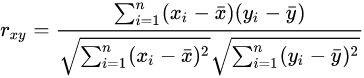

Where the dividend represents a measure of covariance between dimensions, whereas the divisor is the product of the standard deviation of the scores given by each user.

In [ ]:
def sim_pearson(p1, p2, prefs=critics, verbose=False):
    '''
    Returns the Pearson correlation coefficient for p1 and p2.
    '''

    '''Step 1: Get the list of mutually rated items'''
    common_items = []
    dic = {}
    for movie in prefs[p1]:
        if movie in prefs[p2]:
            common_items.append(movie)
    # If they are no ratings in common, return 0
    if len(common_items) == 0:
        return 0
    '''Step 2: Sum calculations'''
    n_common_items = len(common_items)
    sum1 = sum([prefs[p1][movie] for movie in common_items])
    sum2 = sum([prefs[p2][movie] for movie in common_items])
    # Sums of squares
    sum1Sq = sum([pow(prefs[p1][movie], 2) for movie in common_items])
    sum2Sq = sum([pow(prefs[p2][movie], 2) for movie in common_items])
    # Sum of the products
    pSum = sum([prefs[p1][movie] * prefs[p2][movie] for movie in common_items])
    # Calculate r (Pearson score)
    num = pSum - sum1 * sum2 / n_common_items
    den = sqrt((sum1Sq - pow(sum1, 2) / n_common_items) * (sum2Sq - pow(sum2, 2) / n_common_items))
    if den == 0:
        return 0
    r = num / den
    if verbose:
        print("common dimensions: %s" % len(common_items))
        print("Similarity Score for {} and {}: {}".format(p1, p2, r))
    return r

# for k in critics.keys():
#     sim_pearson('Michael Phillips', k, verbose=True)

Try the examples you used for the eucledian distance again, but now using the pearson correlation:

In [ ]:
sim_pearson('Lisa Rose','Gene Seymour')

### Ranking critics on similarity
The topMatches function below calculates all similarities of a given critic with his peers:

In [ ]:
def topMatches(person, n=5, similarity=sim_pearson, prefs=critics):
    '''
    Returns the best matches for person from the prefs dictionary. 
    Number of results and similarity function are optional params.
    '''
    if similarity not in [sim_distance, sim_pearson]:
        # NB: here we are comparing FUNCTION DEFINITION.
        # We do that only in a jupyter notebook for the sake of simplicity.
        raise ValueError("Callback functions should be: 'sim_pearson' or 'sim_distance'.")
        
    scores = [(similarity(person, other, prefs=prefs), other) for other in prefs
              if other != person]
    scores.sort()
    scores.reverse()
    return scores[0:n]

So you can now get the 3 critics closest to Toby by calling:

In [ ]:
topMatches('Toby',n=3)

*****************************************************
### Task: Effect of similarity function used
Call the topMatches function on a number of critics with both the default sim_pearson, but also with the sim_distance function. Would you have preference of one over the other? 
*****************************************************

In [ ]:
for critic in critics.keys():
    print(critic)
    print(topMatches(critic,n=3))
    print(topMatches(critic,n=3,similarity=sim_distance))
    print("_____________")

Describe differences found here. 

use pearson because of the ordinal nature of movie data.
Furthermore, its scale irrelevatn (described above) and directional relationship.

### **Exercise 2: Recommending Items**

One way to recommend movies to a person would be to rate the movies she has not seen yet by using the scores of the others weighted by the similarity.

In [ ]:
def getRecommendations(person, similarity=sim_pearson, prefs=critics):
    '''
    Gets recommendations for a person by using a weighted average
    of every other user's rankings
    '''
    if similarity not in [sim_distance, sim_pearson]:
        raise ValueError("Callback functions should be: 'sim_pearson' or 'sim_distance'.")

    totals = {}
    simSums = {}
    for other in prefs:
    # Don't compare me to myself
        if other == person:
            continue
        # print(person, other)
        sim = similarity(person, other, prefs=prefs)
    # Ignore scores of zero or lower
        if sim <= 0: 
            continue
        for item in prefs[other]:
            # Only score movies I haven't seen yet
            if item not in prefs[person] or prefs[person][item] == 0:
                # Similarity * Score
                    totals.setdefault(item, 0)
                    # The final score is calculated by multiplying each item by the
                    #   similarity and adding these products together
                    totals[item] += prefs[other][item] * sim
                    # Sum of similarities
                    simSums.setdefault(item, 0)
                    simSums[item] += sim
    # Create the normalized list
    rankings = [(total / simSums[item], item) for (item, total) in
                totals.items()]
    # Return the sorted list
    rankings.sort()
    rankings.reverse()
    return rankings

In [ ]:
getRecommendations('Toby', similarity=sim_distance)

In [ ]:
getRecommendations('Toby')


Note that the output does not only consist of a movie title, but also a guess at what the user's rating for each movie would be.

*****************************************************
### Task: Explainable recommendations
Can you also find out how to give information on how the recommendation is built up. For example about the 'closest' person that also watched this movie?
*****************************************************

In [ ]:
# Your code here
# 
#
#
#
#

In [ ]:
getRecommendations_plus('Toby')

### **Exercise 3: Transformations** 
**You have been building recommendations based on similar users in Exercise 2, but you could of course also build recommendations based on similar items. In this exercise you will do this.** 

The function is essentially the same, but you need to transfer your data, from:

<code>{'Lisa Rose': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.5},
'Gene Seymour': {'Lady in the Water': 3.0, 'Snakes on a Plane': 3.5}}</code>

to

<code>{'Lady in the Water': {'Lisa Rose': 2.5,'Gene Seymour': 3.0},
'Snakes on a Plane': {'Lisa Rose': 3.5,'Gene Seymour': 3.5}}</code>

This is what the transformPrefs function does. 

You can now create a dictionary for movies with their scores assigned by different people by invoking:

In [ ]:
def transformPrefs(prefs=critics):
    '''
    Transform the recommendations into a mapping where persons are described
    with interest scores for a given title e.g. {title: person} instead of
    {person: title}.
    '''
    result = {}
    for person in prefs:
        for item in prefs[person]:
            result.setdefault(item, {})
            # Flip item and person
            result[item][person] = prefs[person][item]
    return result

In [ ]:
movies = transformPrefs()
print(movies)

And find similar items for a particular movie like this:

In [ ]:
topMatches('Superman Returns', prefs=movies)

Or find people who may like a particular movie:

In [ ]:
getRecommendations('Just My Luck', prefs=movies)

*****************************************************
#### Task: why does the example above work?
Try to follow exactly what is going on in the last call. Notice that Michael and Jack did not rate 'Just my Luck'. How is their rating for it built up?
*****************************************************

Now the dataset has been restructured to a movie-centric format (movie:user:rating).
So the similarity functions calculate for each user who has not rated 'Just My Luck', a similarity score with those who have rated it. The similarity score is based on how similarly two users rate other movies they've both seen.
For each user who hasn't seen 'Just My Luck', the function estimates a rating by weighted averaging. It does this by taking each rating of 'Just My Luck' by other users, multiplying these ratings by the similarity score between the non-rater and the rater, and summing these products.
The result is a list of users with their estimated enjoyment of 'Just My Luck', ranked from highest to lowest.
In the case of Michael and Jack, who did not rate 'Just My Luck', the function predicts their rating for the movie based on how similar their tastes are to those who have rated the movie. If Michael, for example, has tastes very similar to users who liked 'Just My Luck', then the predicted rating for Michael will be high. Conversely, if his tastes align more with users who rated the movie poorly, the predicted rating will be lower.

### **Exercise 4: Sentence Similarity**

In [ ]:
# import natural language processing software we need later.
import nltk
from nltk.stem import WordNetLemmatizer


In [ ]:
# Download wordnet and punkt sentence tokenizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')


Below we have some example sentences to compare later on.

In [ ]:
movies = ["I saw a really good movie last night.",
"The movie is based on the director's life.",
"The movie starts at ten.",
"I took her to a movie.",
"The movie stars Al Pacino.",
"The movie opened last weekend.",
"The movie lasted two hours.",
"He directed several movies.", 
"We just shot another movie.", 
"The movie was set in New York."]

In [ ]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

To get the Jaccard Similarity of two sentences however, we first need to do some preprocessing in the form of Lemmatization and Tokenization.

In [ ]:
def compare(s1, s2):

    #Import a Lemmatizer to get the root form of certain words
    lemmatizer = WordNetLemmatizer() 
    
    #Tokenize both sentences to get each word separately
    word_list1 = nltk.word_tokenize(s1)
    word_list2 = nltk.word_tokenize(s2)
    
#     print("Tokenized sentence", word_list1) #Uncomment to see an example of the tokenized sentence 
    
    #Lemmatize both sentences
    lemmatized_output1 = ' '.join([lemmatizer.lemmatize(w, 'v') for w in word_list1])
    lemmatized_output2 = ' '.join([lemmatizer.lemmatize(w, 'v') for w in word_list2])
    #print(lemmatized_output2)
    return lemmatized_output1, lemmatized_output2

In [ ]:
from nltk.stem import WordNetLemmatizer
for x in range(len(movies)):
    l1, l2 = compare(movies[0], movies[x])
    print("Sentence 1:", l1, '\n', "Sentence 2:", l2, '\n', "Similarity Score:", get_jaccard_sim(l1,l2))

*****************************************************
#### Task: In what scenario's could the Jaccard Similarity be more useful than the Euclidean distance and the Pearson Similarity metrics? Why is that? 
*****************************************************

The jaccard similarity measures similarity between sets by dividing the intersection by the union of two sets. So in a case where two sets are 100% identical union and intersection are identical == 1. If they do not have any shared elements, then the intersection is empty so 0/some number == 0. For comparisons where it is hard to give definete real values (as we have the case here), the jaccard similarity is a better pick. A possible solution would be to one hot encode appearing words to apply pearson/euclidean similarity, but with more extensive vocabulary these measure start to fail quickly as the vectors tend to get very scarce (Curse of Dimensionality: With increasing dimensions, Euclidean distances tend to become less meaningful, and the Pearson correlation can be less informative due to the lack of variance in most dimensions). Also: jaccard distance better at Handling Outliers and Non-Normal Distributions.

### **Exercise 5: Building a Reddit Recommender**

After having created your Reddit account, go to User Settings -> Safety & Privacy -> Manage third-party app authorization.
Here, you will create your own app. Give it a name, and add "https://www.reddit.com/prefs/apps/ " to the redirect uri. Keep the other settings as they are.
You may encounter some issues accessing "https://www.reddit.com/prefs/apps/ " in Chrome. If so, try with another browser.

* replace the '???' in the user_agent string with your name (or any unique string).
* replace the '???' in the client_id with the id right underneath your web app name.
* replace the '???' in the client_secret with the key next to 'secret'.

NOTE: install praw v. 3.5 


In [ ]:
# -*- coding: utf-8 -*-

import praw
import time

#Delete keys before handing in the notebook
r = praw.Reddit(user_agent=???, client_id=???,
                      client_secret=???,
                      redirect_url='https://www.reddit.com/prefs/apps/'
                                   'authorize_callback')


def initializeUserDict(subreddit, count=10):
    user_dict={}
    # get the top count' popular posts
    for post in r.subreddit(subreddit).top(limit=count):
        # find all users who commented in this
        flat_comments = post.comments.list()
        for comment in flat_comments:
            try:
                user = comment.author.name
                user_dict[user] = {}
            except AttributeError:
                pass
    return user_dict

def fillItems(user_dict, count=100):
    all_items={}
    # Find links posted by all users
    for user in user_dict:
        # print("finding subreddits where user " + user + "has commented")
        # find new comments for given user
        comments = r.redditor(user).comments.new(limit=count)
        for c in comments:
            # Get the subreddit where the comment was made
            subreddit = c.subreddit
            sub_name = subreddit.display_name
            # print(sub_name)
            if sub_name in user_dict[user]:
                user_dict[user][sub_name] += 1.0
            else:
                user_dict[user][sub_name] = 1.0
            
            all_items[sub_name] = 1
#     Fill in missing items with 0
#     for subr_counts in user_dict.values():
#         for item in all_items:
#             if item not in subr_counts:
#                 subr_counts[item]=0.0
    
    return user_dict
 

You can get a list of popular recent posts about programming from the programming subreddit (https://www.reddit.com/r/VUAmsterdam) by invoking the code below.  Don't forget to replace the '???' in the user_agent string with your name (or any unique string).

In [ ]:
print("praw version == " + praw.__version__)

subreddit = r.subreddit("programming")
for post in r.subreddit('VUAmsterdam').top(limit=5):
    print(end='\n * ')
    print(post.title)

See here a list of other subreddits you can explore with this code: https://www.reddit.com/reddits/

To automatically create a data set of reddit users similar to the movie watchers you can invoke the initializeUserDict function in redditrec.py 

In [ ]:
red_users=initializeUserDict('VUAmsterdam', count=10) # or for any other subreddit
print(red_users)

Now initializeUserDict has only created the user keys. We of course also want to know what subreddits they posted comments on. You can pull those in through:

In [ ]:
dict_ = fillItems(red_users, count=50)
# here you can see how often each user commented in what sub.

This script may take a few minutes to collect all the data. Use this time to review what is going on in the code. Notice that users don't give ratings to subreddits, instead we are counting how many comments they posted in each subreddit. 

To recommend a similar user, we can use our topMatches function again.

First choose a random user for whom you're going to find neighbours

In [ ]:
import random
user= random.choice( list( red_users.keys() ))
print(user) # print the username 
topMatches(user, prefs=red_users) # from all redditors, get the most similar to user

If no similar user was found, you can try increasing the count of users or comments for each initializeUserDict and fillItems.

*****************************************************
#### Task: Recommend subreddits for a user based on what subreddits similar users have commented in. Recommend posts for a user based on posts they have commented on. 
*****************************************************

In [ ]:
def jaccard_similarity(user1, user2, prefs):
    # Extracting the sets of subreddits for each user
    set1 = set(prefs[user1].keys())
    set2 = set(prefs[user2].keys())

    # Calculating intersection and union
    intersection = set1.intersection(set2)
    union = set1.union(set2)

    # Handling division by zero in case both sets are empty
    if len(union) == 0:
        return 0

    # Calculating Jaccard Similarity
    return len(intersection) / len(union)


In [ ]:
def getRecommendations1(target_user, prefs):
    totals = {}
    simSums = {}

    for other_user in prefs:
        # Skip similarity with self
        if other_user == target_user:
            continue

        sim = jaccard_similarity(target_user, other_user, prefs)

        # Ignore scores of zero or lower
        if sim <= 0:
            continue

        for subreddit in prefs[other_user]:
            # Recommend only subreddits target user hasn't commented on
            if subreddit not in prefs[target_user] or prefs[target_user][subreddit] == 0:
                # Similarity * Comment Frequency
                totals.setdefault(subreddit, 0)
                totals[subreddit] += prefs[other_user][subreddit] * sim
                # Sum of similarities
                simSums.setdefault(subreddit, 0)
                simSums[subreddit] += sim

    # Create a normalized list
    rankings = [(total / simSums[subreddit], subreddit) for subreddit, total in totals.items()]

    # Return the sorted list
    rankings.sort(reverse=True)
    return rankings


In [ ]:
getRecommendations1("alecsferra",dict_)

In [ ]:
def fillItems1(user_dict, count=100):
    all_items = {}
    # Find comments made by all users
    for user in user_dict:
        # Find new comments for the given user
        comments = r.redditor(user).comments.new(limit=count)
        for comment in comments:
            # Get the submission (post) where the comment was made
            submission = comment.submission
            print(submission_id)
            submission_id = submission.id
            print(submission_id)
            if submission_id in user_dict[user]:
                user_dict[user][submission_id] += 1.0
            else:
                user_dict[user][submission_id] = 1.0

            all_items[submission_id] = 1
    
    return user_dict


In [ ]:
red_users=initializeUserDict('VUAmsterdam', count=10) # or for any other subreddit
print(red_users)

In [ ]:
dict_ = fillItems1(red_users, count=50)
# here you can see how often each user commented in what sub.

In [ ]:
dict_

In [ ]:
getRecommendations1("Honey_2525",dict_)

In [ ]:
post = r.submission(id="pf9bv4")

# Print information about the post
print("Post Title:", post.title)
print("Author:", post.author)
print("Subreddit:", post.subreddit.display_name)
print("Score:", post.score)
print("Number of Comments:", post.num_comments)